In [1]:
!mkdir -p results

# Imports

#### General

In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from livelossplot import PlotLossesKeras

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Tensorflow and NumPy

In [3]:
random_state = 1
import numpy as np
np.random.seed(random_state)
import random
random.seed(random_state)
import tensorflow
tensorflow.set_random_seed(random_state)

#### Sci-Kit Learn

In [4]:
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.metrics import mean_squared_error

#### Keras

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

# Data

In [6]:
train = pd.read_csv('../feature_engineering/train.gz')
X_train = train[train.columns[:-1]].values
y_train = train[train.columns[-1]].values

In [7]:
test = pd.read_csv('../feature_engineering/test.gz')
X_test = test[test.columns[:-1]].values
y_test = test[test.columns[-1]].values

# Models

In [8]:
rf = RandomForestRegressor(
    bootstrap=False, 
    criterion='mse', 
    max_depth=None,
    max_features='sqrt', 
    max_leaf_nodes=None,
    min_impurity_decrease=0.001, 
    min_impurity_split=None,
    min_samples_leaf=8, 
    min_samples_split=8,
    min_weight_fraction_leaf=0.0, 
    n_estimators=17, 
    n_jobs=1,
    oob_score=False, 
    random_state=random_state, 
    verbose=0, 
    warm_start=False
)
rf

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [9]:
br = BayesianRidge(
    alpha_1=1, 
    alpha_2=1, 
    compute_score=False, 
    copy_X=True,
    fit_intercept=True, 
    lambda_1=1, 
    lambda_2=1.0, 
    n_iter=1,
    normalize=False, 
    tol=0.001, 
    verbose=False
)
br

BayesianRidge(alpha_1=1, alpha_2=1, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1, lambda_2=1.0, n_iter=1,
       normalize=False, tol=0.001, verbose=False)

In [10]:
gb = GradientBoostingRegressor(
    alpha=0.9, 
    criterion='friedman_mse', 
    init=None,
    learning_rate=0.3, 
    loss='ls', 
    max_depth=10, 
    max_features=None,
    max_leaf_nodes=100, 
    min_impurity_decrease=0.2,
    min_impurity_split=None, 
    min_samples_leaf=9,
    min_samples_split=3, 
    min_weight_fraction_leaf=0.0,
    n_estimators=21, 
    presort='auto', 
    random_state=random_state,
    subsample=1.0, 
    verbose=0, 
    warm_start=False
)
gb

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=100, min_impurity_decrease=0.2,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=21, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

In [11]:
models = {
    rf.__class__.__name__: rf, 
    br.__class__.__name__: br, 
    gb.__class__.__name__: gb
}

#### Fit

In [12]:
for _, model in models.items():
    model.fit(X_train, y_train)

#### Predict

In [13]:
predictions = {name: model.predict(X_train) for (name, model) in models.items()}

In [14]:
train_df = pd.DataFrame(predictions)
train_df['Truth'] = y_train

In [15]:
train_df.head()

,BayesianRidge,GradientBoostingRegressor,RandomForestRegressor,Truth
0,9.769505,13.392991,14.763702,15.55904
1,9.102280,12.998163,13.856789,14.43644
2,7.467854,10.487035,12.983188,13.24040
3,7.063342,10.487035,13.138361,13.49220
4,7.807087,10.463812,13.663825,12.67385


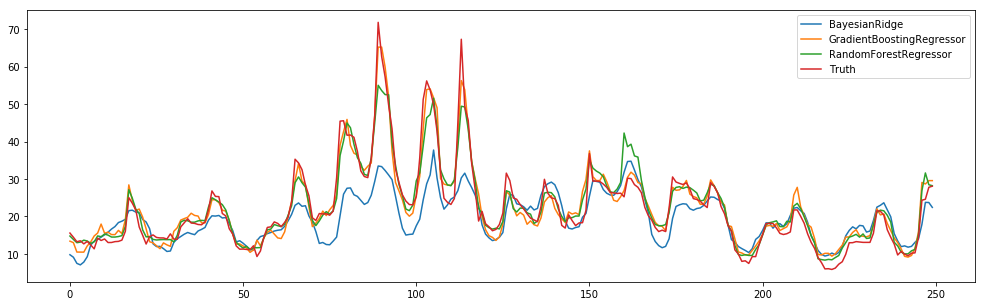

In [16]:
_ = train_df[:250].plot(figsize=(17, 5))

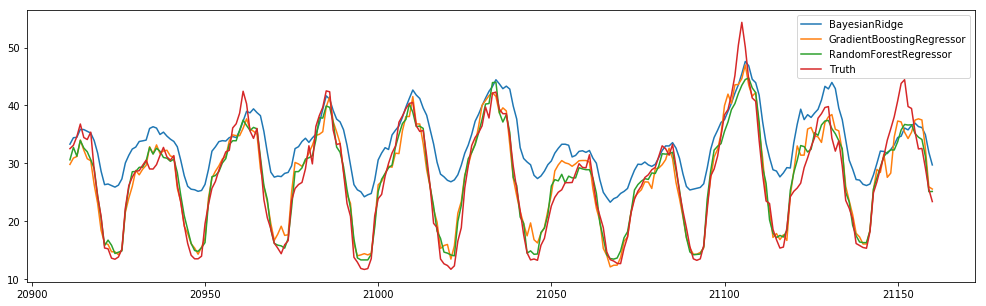

In [17]:
_ = train_df[-250:].plot(figsize=(17, 5))

#### Generate Error

In [18]:
error_df = (train_df.T - y_train.T).T
error_df.head()

,BayesianRidge,GradientBoostingRegressor,RandomForestRegressor,Truth
0,-5.789535,-2.166049,-0.795338,0.0
1,-5.334160,-1.438277,-0.579651,0.0
2,-5.772546,-2.753365,-0.257212,0.0
3,-6.428858,-3.005165,-0.353839,0.0
4,-4.866763,-2.210038,0.989975,0.0


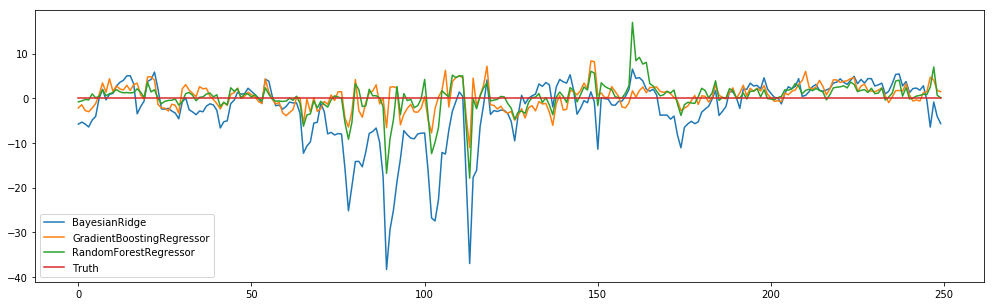

In [19]:
_ = error_df[:250].plot(figsize=(17, 5))

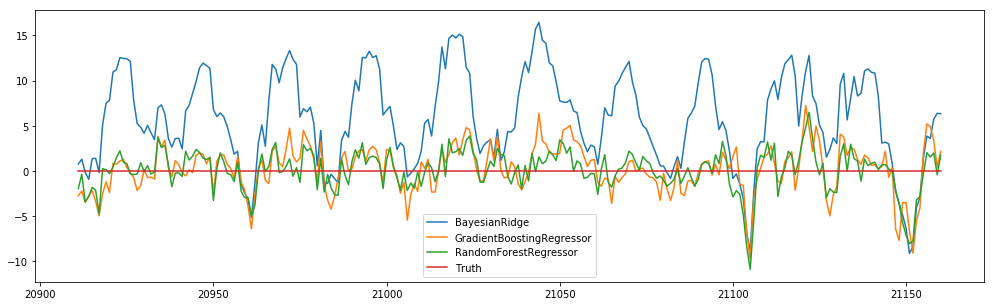

In [20]:
_ = error_df[-250:].plot(figsize=(17, 5))

#### Generate Predictive Model

##### 2 ideas

-   regress the actual error and use the model with the lowest predicted error (**implemented here**)
-   for each time step, assign a label of 1 to the regressor with the lowest error (**NOT implemented here**)

In [21]:
model_selector = error_df.copy()
del model_selector['Truth']

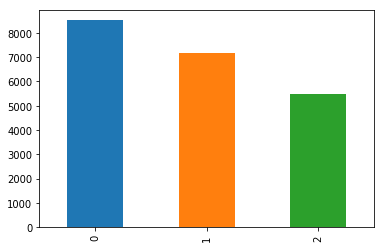

In [22]:
# calculate the column index of the model with the lowest error
min_errors = np.argmin(model_selector.values, axis=1)
_ = pd.Series(min_errors).value_counts().plot(kind='bar')

In [23]:
model_selector.shape[1]

3

In [24]:
def build_model(
    input_dim: tuple=X_train.shape[1],
    output_dim: tuple=model_selector.shape[1],
) -> Sequential:
    """Build and compile a sequential Keras model (FFNN)."""
    # clear the Keras session (only applies to keras models, but 
    # wont hurt sklearn ones to call this)
    K.clear_session()
    # build the model
    model = Sequential([
        # Block 1
        Dense(32, input_dim=input_dim),
        PReLU(),
        BatchNormalization(),
        Dropout(0.2),
        # Block 2
        Dense(16),
        PReLU(),
        BatchNormalization(),
        Dropout(0.2),
        # Block 3
        Dense(8),
        PReLU(),
        BatchNormalization(),
        Dropout(0.2),
        # Output Block
        Dense(output_dim)
    ])
    # compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam())
    
    return model

In [25]:
ann = KerasRegressor(build_fn=build_model, epochs=500, batch_size=10000, verbose=0)

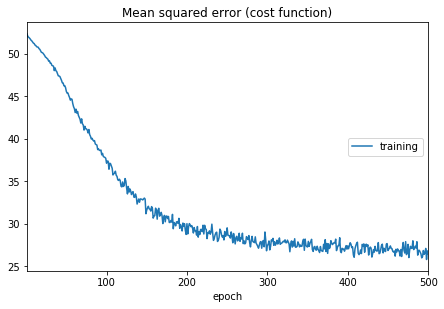

In [26]:
history = ann.fit(X_train, model_selector.values, callbacks=[PlotLossesKeras()])

In [27]:
def get_predictions(X: np.ndarray) -> np.ndarray:
    """
    Generate ensemble predictions for the given dataset.
    
    Args:
        X: the dataset to get predictions from the model for
        
    Returns:
        a vector of predictions from the ensemble
        
    """
    # create an empty list to store predictions in 
    preds = []

    # iterate over each sample in the dataset
    for Xi in tqdm(X):
        # get the output from the loss network
        ann_out = ann.predict(Xi.reshape(1, len(Xi)), verbose=0)
        # determine the index with the lowest loss
        clf_idx = np.argmin(ann_out)
        # unwrap the models key and extract it from the dictionary
        model_key = model_selector.columns[clf_idx]
        model = models[model_key]
        # get the actual prediction from the model
        pred = model.predict(Xi.reshape(1, len(Xi)))
        # append the prediction to the list for this value
        preds.append(pred)

    # reshape the values into a single vector
    return np.array(preds).reshape(-1)

In [28]:
train_preds = get_predictions(X_train)

100%|██████████| 21161/21161 [00:29<00:00, 712.43it/s]


In [29]:
train_df = pd.DataFrame([y_train, np.array(train_preds).reshape(-1)], index=['Truth', 'Predictions']).T

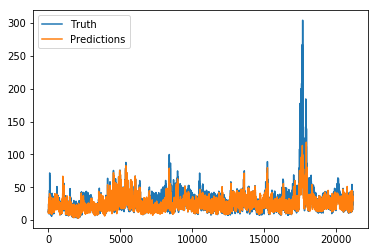

In [30]:
_ = train_df.plot()

In [31]:
train_err = np.mean((train_df['Truth'] - train_df['Predictions'])**2)
train_err

101.10707260108069

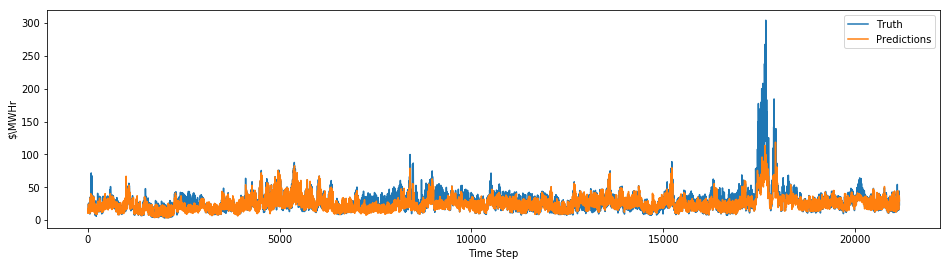

In [32]:
ax = train_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/perv-train.pdf')
plt.savefig('results/perv-train.svg')

In [33]:
test_preds = get_predictions(X_test)

100%|██████████| 767/767 [00:00<00:00, 834.34it/s]


In [34]:
test_df = pd.DataFrame([y_test, test_preds], index=['Truth', 'Predictions']).T

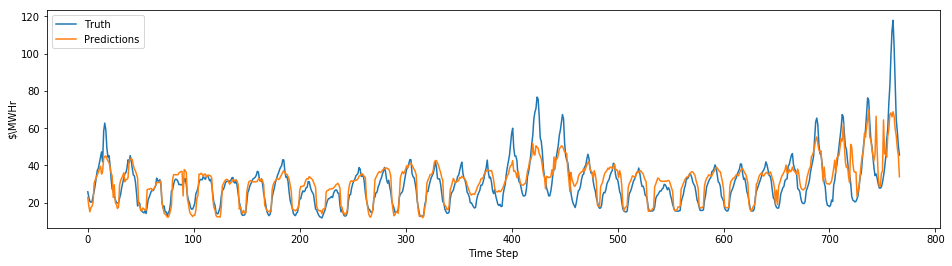

In [35]:
ax = test_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/perv-test.pdf')
plt.savefig('results/perv-test.svg')

In [36]:
test_err = np.mean((test_df['Truth'] - test_df['Predictions'])**2)
test_err

48.07903503120162

# Results

In [37]:
results = pd.Series([train_err, test_err], index=['Train', 'Test'])
results

Train    101.107073
Test      48.079035
dtype: float64

In [38]:
results.to_csv('results/perv-mse.csv')